In [ ]:
## Notebook env: brian_script_env (R kernel)
## evaluating proliferation effects of selected guides

In [1]:
library(ggplot2)
library(tidyr)
library(dplyr)
library(ggpubr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




### Analysis

In [2]:
## note 5k cells seeded per well in this assay
## load in data
cyclo_selected_guides_proliferation_assay = read.csv('/home/ssobti/projects/heterogeneity_brian/data/proliferation_assays/bw052424cyclo.txt', sep='\t', header=T)
dox_selected_guides_proliferation_assay = read.csv('/home/ssobti/projects/heterogeneity_brian/data/proliferation_assays/bw052424dox.txt', sep='\t', header=T)
taxol_selected_guides_proliferation_assay = read.csv('/home/ssobti/projects/heterogeneity_brian/data/proliferation_assays/bw052424taxol.txt', sep='\t', header=T)
untreated_selected_guides_proliferation_assay = read.csv('/home/ssobti/projects/heterogeneity_brian/data/proliferation_assays/bw052424untreatl.txt', sep='\t', header=T)
prolif_assays = list(untreated_selected_guides_proliferation_assay, cyclo_selected_guides_proliferation_assay, dox_selected_guides_proliferation_assay, taxol_selected_guides_proliferation_assay)
prolif_assays = lapply(prolif_assays, function(x) x[!colnames(x) %in% 'Date.Time'])
names(prolif_assays) = c('untreated', 'cyclo', 'dox', 'taxol')
guide_names = c('RNF8A-CRISPRi', 'MIS18A-CRIPSRi', 'RUVBL1-CRISPRi', 'VRK1-CRISPRi', 'HMGA1-CRISPRi', 'RNF8A-CRISPRa', 'MIS18A-CRISPRa', 'NT', 'NTCA')
column_names = as.character(unlist(sapply(c('100uM', '10uM','1uM','0.1uM'), function(x) paste(x, guide_names, sep=' '), simplify = FALSE)))

for (i in 1:length(prolif_assays)){
    if(names(prolif_assays)[i] != 'untreated'){
        prolif_assays[[i]] = prolif_assays[[i]][!endsWith(colnames(prolif_assays[[i]]), 'Std.Err.Img.')]
        colnames(prolif_assays[[i]])[!colnames(prolif_assays[[i]]) %in% 'Elapsed'] = column_names
    } else{
        prolif_assays[[i]] = prolif_assays[[i]][!endsWith(colnames(prolif_assays[[i]]), 'Std.Err.Img.')]
        colnames(prolif_assays[[i]])[!colnames(prolif_assays[[i]]) %in% 'Elapsed'] = guide_names
    }    
}

head(prolif_assays[[1]])


,Elapsed,RNF8A-CRISPRi,MIS18A-CRIPSRi,RUVBL1-CRISPRi,VRK1-CRISPRi,HMGA1-CRISPRi,RNF8A-CRISPRa,MIS18A-CRISPRa,NT,NTCA
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,8.880176,9.917171,12.16036,14.54172,20.17559,8.118435,9.649572,9.057557,6.792986
2,6,10.644410,12.100650,15.16487,18.03349,24.24615,9.568899,11.861030,11.471830,8.043298
3,12,12.201190,13.944480,17.00279,20.46585,27.76728,11.085140,13.849130,13.172840,9.130415
4,18,14.020060,16.566870,19.92550,23.87869,32.35033,12.789570,16.054050,15.854940,10.570650
5,24,16.102990,19.808810,23.20474,27.67649,36.79584,14.634060,18.282200,18.949980,12.158700
6,30,18.047400,22.874610,27.08812,31.40517,41.37396,16.564670,20.718830,22.011700,13.882020


In [3]:
## calculate growth rate from curves line fit
## fitted line slopes logged

log2_prolif_assays = lapply(prolif_assays, function(x) cbind('Elapsed hours' = x$Elapsed, x %>% select(-`Elapsed`) %>% log2()))
slopes_list = list()
errors_list = list()

# slopes_df = data.frame(matrix(0, length(log2_prolif_assays) - 1, ncol(log2_prolif_assays[[1]]) - 1))
# errors_df = data.frame(matrix(0, length(log2_prolif_assays) - 1, ncol(log2_prolif_assays[[1]]) - 1))
slopes = list()
errors = list()

for (j in 1:length(log2_prolif_assays)){
    n = 1
    for (i in 1:length(colnames(log2_prolif_assays[[j]]))){
        if (i > 1){
            slopes[[n]] = as.numeric(coef(lm(log2_prolif_assays[[j]][,i] ~ log2_prolif_assays[[j]]$`Elapsed hours`))[2])
            limits = abs(slopes[[n]] - as.numeric(confint(lm(log2_prolif_assays[[j]][,i] ~ log2_prolif_assays[[j]]$`Elapsed hours`))[2,]))
            errors[[n]] = mean(abs(limits[2]) + abs(limits[1]))
            n = n + 1
        }
    }
    slopes_list[[j]] = unlist(slopes)
    errors_list[[j]] = unlist(errors)
}

names(slopes_list) = names(errors_list) = names(prolif_assays)

Warning message:
“The shape palette can deal with a maximum of 6 discrete values because
more than 6 becomes difficult to discriminate; you have 9. Consider
specifying shapes manually if you must have them.”
Warning message:
“Removed 15 rows containing missing values (geom_point).”
Warning message:
“The shape palette can deal with a maximum of 6 discrete values because
more than 6 becomes difficult to discriminate; you have 9. Consider
specifying shapes manually if you must have them.”
Warning message:
“Removed 15 rows containing missing values (geom_point).”
Warning message:
“The shape palette can deal with a maximum of 6 discrete values because
more than 6 becomes difficult to discriminate; you have 9. Consider
specifying shapes manually if you must have them.”
Warning message:
“Removed 15 rows containing missing values (geom_point).”
Warning message:
“The shape palette can deal with a maximum of 6 discrete values because
more than 6 becomes difficult to discriminate; you have 9. Con

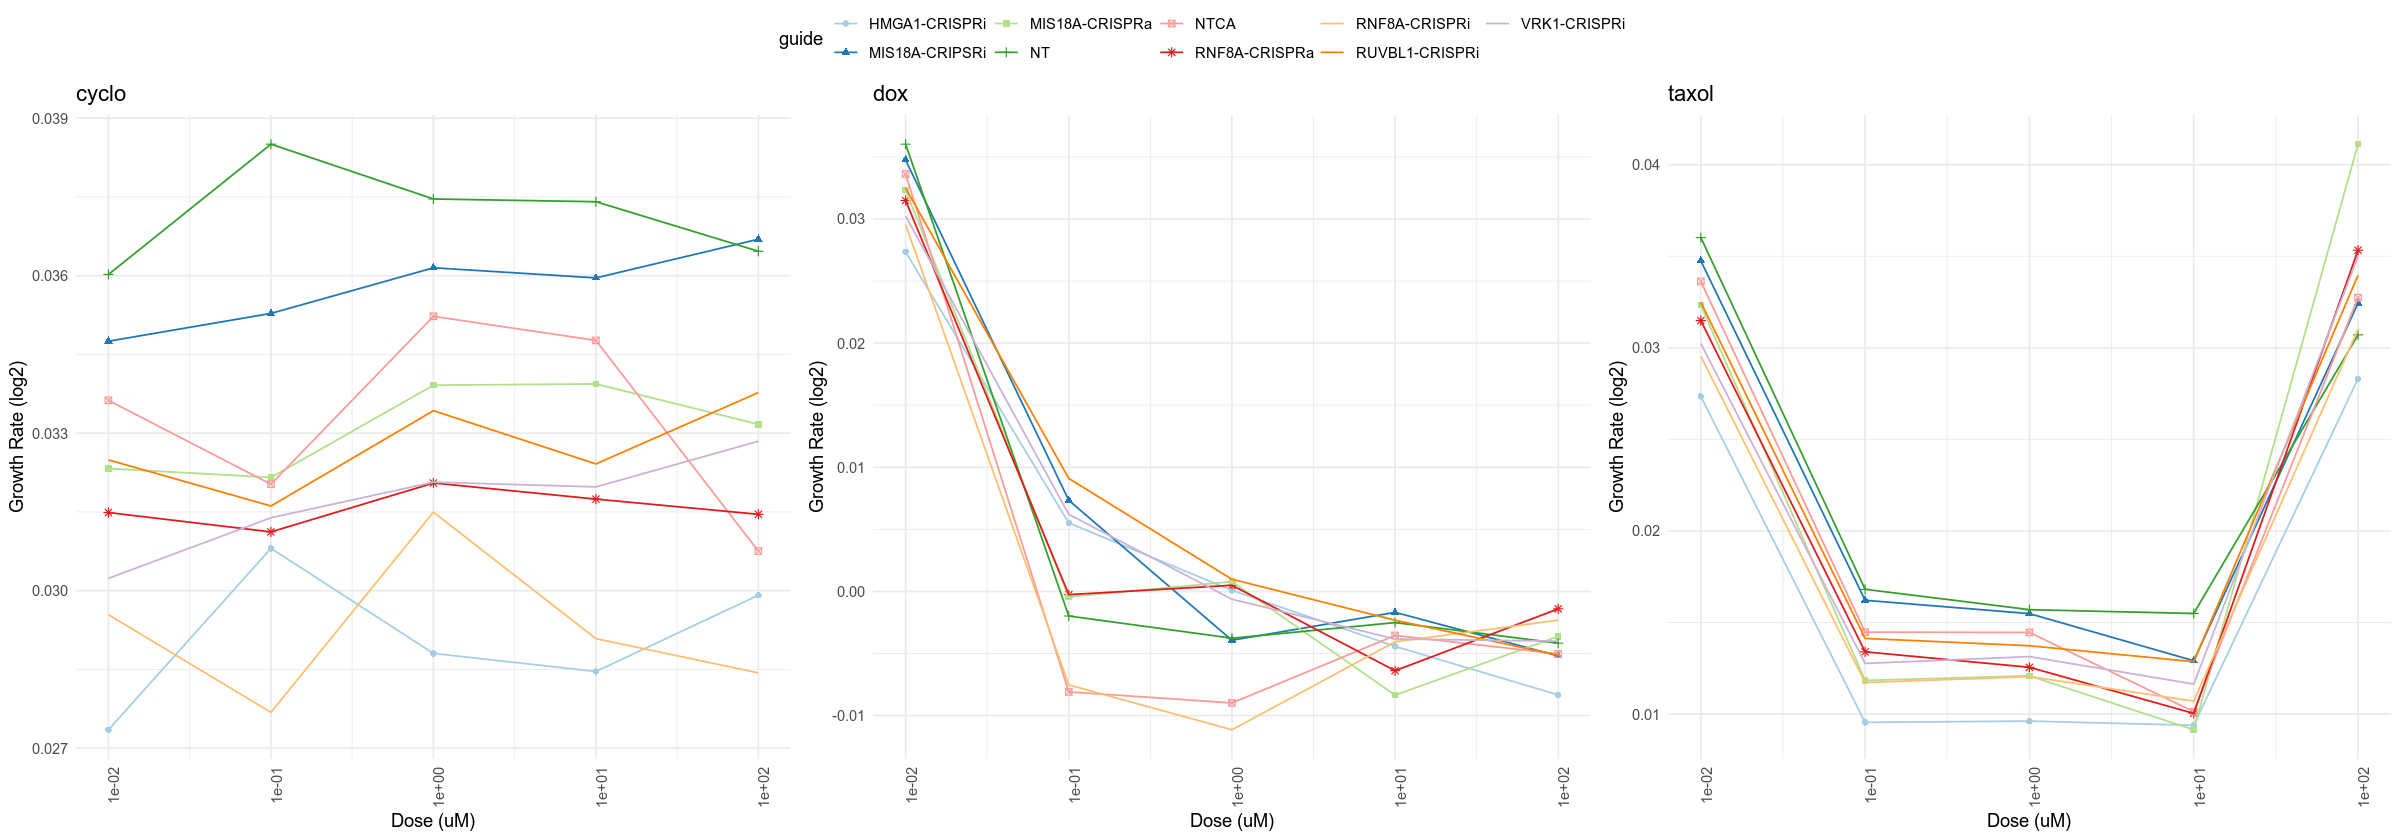

In [71]:
options(repr.plot.width=20, repr.plot.height=7)
## make a x,y plot of dose vs growth rate (slope)
## error bars are 95% confidence intervals
## plot for each drug treatment
library(stringr)
xy_plot_dfs = list()
xy_plots = list()

for (i in 1:(length(log2_prolif_assays[-1]))){
    dose_names = colnames(log2_prolif_assays[[i + 1]])[!colnames(log2_prolif_assays[[i + 1]]) %in% 'Elapsed hours']
    drug_df = data.frame(dose = as.numeric(str_sub(sapply(str_split(dose_names, pattern = ' '), '[', 1), end = -3)), guide = sapply(str_split(dose_names, pattern = ' '), '[', 2), growth_rate = slopes_list[[i + 1]], error = errors_list[[i + 1]])
    control_df = data.frame(dose = as.numeric('0.01'), guide = guide_names, growth_rate = slopes_list[[1]], error = errors_list[[1]])
    drug_df = rbind(drug_df, control_df)
    xy_plot_dfs[[i]] = drug_df
    xy_plots[[i]] = ggplot(drug_df, aes(x=dose, y=growth_rate, color=guide, shape = guide)) + geom_point() + geom_line() + theme_minimal() + theme(axis.text.x = element_text(angle = 90, hjust = 1)) + labs(title= names(log2_prolif_assays)[i+1], x='Dose (uM)', y='Growth Rate (log2)') + scale_x_log10() + scale_color_brewer(palette = 'Paired')
}

ggarrange(plotlist = xy_plots, ncol = 3, nrow = 1, common.legend = TRUE)




In [ ]:
## do barplots at selected doses for each drug

In [ ]:
names(slopes) = colnames(log2_wider_selected_guides_proliferation_assay_mean)[!colnames(log2_wider_selected_guides_proliferation_assay_mean) %in% 'Elapsed hours']
slopes = unlist(slopes)
slopes_df = data.frame(guide = names(slopes[order(slopes)]), slope = slopes[order(slopes)], upper_error = unlist(upper_error), lower_error = unlist(lower_error))
ggplot(data = slopes_df, aes(x = guide, y = slope, fill = guide)) + 
  geom_bar(stat = "identity") + scale_fill_manual(values = colorRampPalette(RColorBrewer::brewer.pal(9, "Blues"))(100)[41:(40 + nrow(slopes_df))]) + geom_errorbar(aes(ymin = slope - lower_error, ymax = slope + upper_error), width=.2) + theme_pubr() + theme(axis.text.x = element_text(angle = 45, hjust = 1))

In [ ]:
## load in data
selected_guides_proliferation_assay = read.csv('/home/ssobti/projects/heterogeneity_brian/data/proliferation_assays/bw052424cyclo.txt', sep='\t', header=T)
guide_names = c('RNF8A-CRISPRi', 'MIS18A-CRIPSRi', 'RUVBL1-CRISPRi', 'VRK1-CRISPRi', 'HMGA1-CRISPRi', 'RNF8A-CRISPRa', 'MIS18A-CRISPRa', 'NT', 'NTCA')
guide_names = c(paste0(guide_names, '_mean'), paste0(guide_names, '_stderror'))
colnames(selected_guides_proliferation_assay) = c('Time Stamp', 'Elapsed hours', guide_names)
selected_guides_proliferation_assay = selected_guides_proliferation_assay[colnames(selected_guides_proliferation_assay) != 'Time Stamp']
head(selected_guides_proliferation_assay)

,Elapsed hours,RNF8A-CRISPRi_mean,MIS18A-CRIPSRi_mean,RUVBL1-CRISPRi_mean,VRK1-CRISPRi_mean,HMGA1-CRISPRi_mean,RNF8A-CRISPRa_mean,MIS18A-CRISPRa_mean,NT_mean,NTCA_mean,RNF8A-CRISPRi_stderror,MIS18A-CRIPSRi_stderror,RUVBL1-CRISPRi_stderror,VRK1-CRISPRi_stderror,HMGA1-CRISPRi_stderror,RNF8A-CRISPRa_stderror,MIS18A-CRISPRa_stderror,NT_stderror,NTCA_stderror
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,6.016636,8.052077,10.65912,13.84767,10.07474,7.324176,7.843402,13.36468,9.541405,0.2288063,0.4326031,0.6461991,0.7342190,0.4510066,0.3569025,0.4317553,0.5854858,0.4599222
2,6,6.860369,9.369484,12.53823,15.91043,11.70815,8.538677,9.351759,15.90000,11.179670,0.2751383,0.5136852,0.7468223,0.8124891,0.5083103,0.4207845,0.5133252,0.7269598,0.5202371
3,12,7.913754,11.025670,14.52379,18.39195,13.58580,9.878489,11.108030,18.78634,13.107650,0.3209719,0.5700140,0.8643790,0.8646275,0.6194807,0.4399621,0.6178789,0.8876463,0.6289871
4,18,8.991703,13.114980,17.23970,21.62921,15.39008,11.731400,12.957090,22.64604,15.269950,0.3913403,0.7378758,1.0252950,1.0329000,0.7070686,0.5565015,0.7046422,1.0652080,0.7456340
5,24,10.032650,15.442770,19.94460,24.80788,17.56866,13.491800,14.825200,26.40834,17.594030,0.4575817,0.8345433,1.1274090,1.1462370,0.8273957,0.6686335,0.8426215,1.2376320,0.9340051
6,30,11.261470,17.646220,22.66936,28.33214,19.53701,15.327290,16.918740,30.06178,20.276390,0.5221288,0.9313806,1.2856880,1.2747680,0.8267910,0.7768459,0.9349344,1.3610590,1.1531010
